In [85]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  8 15:08:44 2022

@author: Wenhao Hsu
"""
from rdkit.Chem import AllChem
from rdkit import Chem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [86]:
# get data set from filepath and do the data cleaning
dataset_path = './data/csv/washed_data_train.csv'
df = pd.read_csv(dataset_path)
df = df.dropna(subset=['Non_fixed?'])
df = df.reset_index(drop=True)
print('\nImported data from '+ dataset_path+', shape: '+str(np.shape(df)))


Imported data from ./data/csv/washed_data_train.csv, shape: (246, 46)


In [87]:
# generate the morgan fingerprints and append it to dataframe
x = df['SMILES']
y = pd.DataFrame(df['lambda_onset']) 
y = np.ravel(y)
print('The shape of morgan-finger print as array x          : '+str(np.shape(x)))
print('The shape of feature as array y                      : '+str(np.shape(y)))

The shape of morgan-finger print as array x          : (246,)
The shape of feature as array y                      : (246,)


In [88]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt


def show_error_plot(y_test,y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()

In [89]:

from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [90]:
from sklearn.base import BaseEstimator, TransformerMixin, _OneToOneFeatureMixin
from sklearn.metrics import mean_absolute_percentage_error

In [91]:
sample_path = './data/csv/washed_data_test.csv'
sample_df = pd.read_csv(sample_path)
sample_df = sample_df.reset_index(drop=True)
# sample_df

In [92]:
x_sample = sample_df['SMILES']
y_sample = sample_df['lambda_onset']

In [93]:
def get_fp_mat( SMILES_list, r = 2, nBits =2048,func = AllChem.GetMorganFingerprintAsBitVect):
    """
    do: generate the morgan-fingerprints and save it as matrix
    SMILES_list: The list of SMILES string
    OUTPUT: morgan-fingerprints matrix
    """
    fps = []
    for SMILES_string in SMILES_list:
        mol = Chem.MolFromSmiles(SMILES_string)
        if func == AllChem.GetMorganFingerprintAsBitVect:
            fp = func(mol,r,useFeatures=False, nBits=nBits).ToBitString()
            fps.append(fp)
        elif func == Chem.RDKFingerprint:
            fp = func(mol = mol,maxPath = r, fpSize=nBits).ToBitString()
            fps.append(fp)
    bits = []
    for fp in fps:
        bit_list = []
        for bit in fp:
            bit_list.append( int(bit) )
        bits.append(bit_list)
    return bits

class fp4knn(BaseEstimator,TransformerMixin): # fingerprints for knn
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X,y=None):
        output = pd.DataFrame(get_fp_mat(X,r = 6,nBits = 2048,func=Chem.RDKFingerprint))
        output['Mol.wt'] = df['Mol.wt']
        output['Non_fixed?'] = df['Non_fixed?']
        return output
class fp4ridge(BaseEstimator,TransformerMixin): # fingerprints for ridge
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X,y=None):
        output = pd.DataFrame(get_fp_mat(X,r = 6,nBits = 2560,func=Chem.RDKFingerprint))
        output['Mol.wt'] = df['Mol.wt']
        output['Non_fixed?'] = df['Non_fixed?']
        return output
class fp4lasso(BaseEstimator,TransformerMixin): # fingerprints for lasso
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X,y=None):
        output = pd.DataFrame(get_fp_mat(X,r = 4,nBits = 2560,func=AllChem.GetMorganFingerprintAsBitVect))
        output['Mol.wt'] = df['Mol.wt']
        output['Non_fixed?'] = df['Non_fixed?']
        return output

In [94]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
plt.rcParams['savefig.dpi'] = 400 #图片像素
plt.rcParams['figure.dpi'] = 400 #分辨率

def get_ensemble(): # define the base models
	models = list()
	knn_pipeline = Pipeline([('get_fp', fp4knn()), ('ss', StandardScaler()), ('knn', KNeighborsRegressor())])
	models.append(('knn', knn_pipeline))
	ridge_pipeline = Pipeline([('get_fp', fp4ridge()), ('ridge', Ridge())])
	models.append(('ridge', ridge_pipeline))
	return models # return a list of tuples each with a name and model

x = df['SMILES'].to_list()
models = get_ensemble()
results_mape = list()
for name,model in models:
	dataset_path = './data/csv/washed_data_train.csv'
	df = pd.read_csv(dataset_path)
	df = df.dropna(subset=['Non_fixed?'])
	df = df.reset_index(drop=True)
	x = df['SMILES'].to_list()

	if name == 'knn':
		model.fit(x,y)

		df = pd.read_csv(sample_path)
		df = df.dropna(subset=['Non_fixed?'])
		df = df.reset_index(drop=True)
		x_sample = df['SMILES']
		y_sample = df['lambda_onset']

		knn_y_pred=model.predict(x_sample)
		score=model.score(x_sample,np.ravel(y_sample))
		print('\n'+name)
		MAPE = mean_absolute_percentage_error(y_sample,knn_y_pred)
		MAE = mean_absolute_error(y_sample,knn_y_pred)
		print(' MAPE：'+str(MAPE)+' MAE：'+str(MAE))
		results_mape.append(MAPE)
		df = pd.read_csv(dataset_path)
	elif name == 'ridge':
		model.fit(x,y)
		
		df = pd.read_csv(sample_path)
		df = df.dropna(subset=['Non_fixed?'])
		df = df.reset_index(drop=True)
		x_sample = df['SMILES']
		y_sample = df['lambda_onset']

		ridge_y_pred=model.predict(x_sample)
		score=model.score(x_sample,np.ravel(y_sample))
		print('\n'+name)
		MAPE = mean_absolute_percentage_error(y_sample,ridge_y_pred)
		MAE = mean_absolute_error(y_sample,ridge_y_pred)
		print(' MAPE：'+str(MAPE)+' MAE：'+str(MAE))
		results_mape.append(MAPE)
		df = pd.read_csv(dataset_path)
new_y_pred = (knn_y_pred+ridge_y_pred)/2
MAPE = mean_absolute_percentage_error(y_sample,new_y_pred)
MAE = mean_absolute_error(y_sample,new_y_pred)
print('\nnew model')
print(' MAPE：'+str(MAPE)+' MAE：'+str(MAE))


knn
 MAPE：0.03185076245027601 MAE：27.573846153846173

ridge
 MAPE：0.04125876433975701 MAE：39.80464649237993

new model
 MAPE：0.03116417030206664 MAE：29.0445112641075


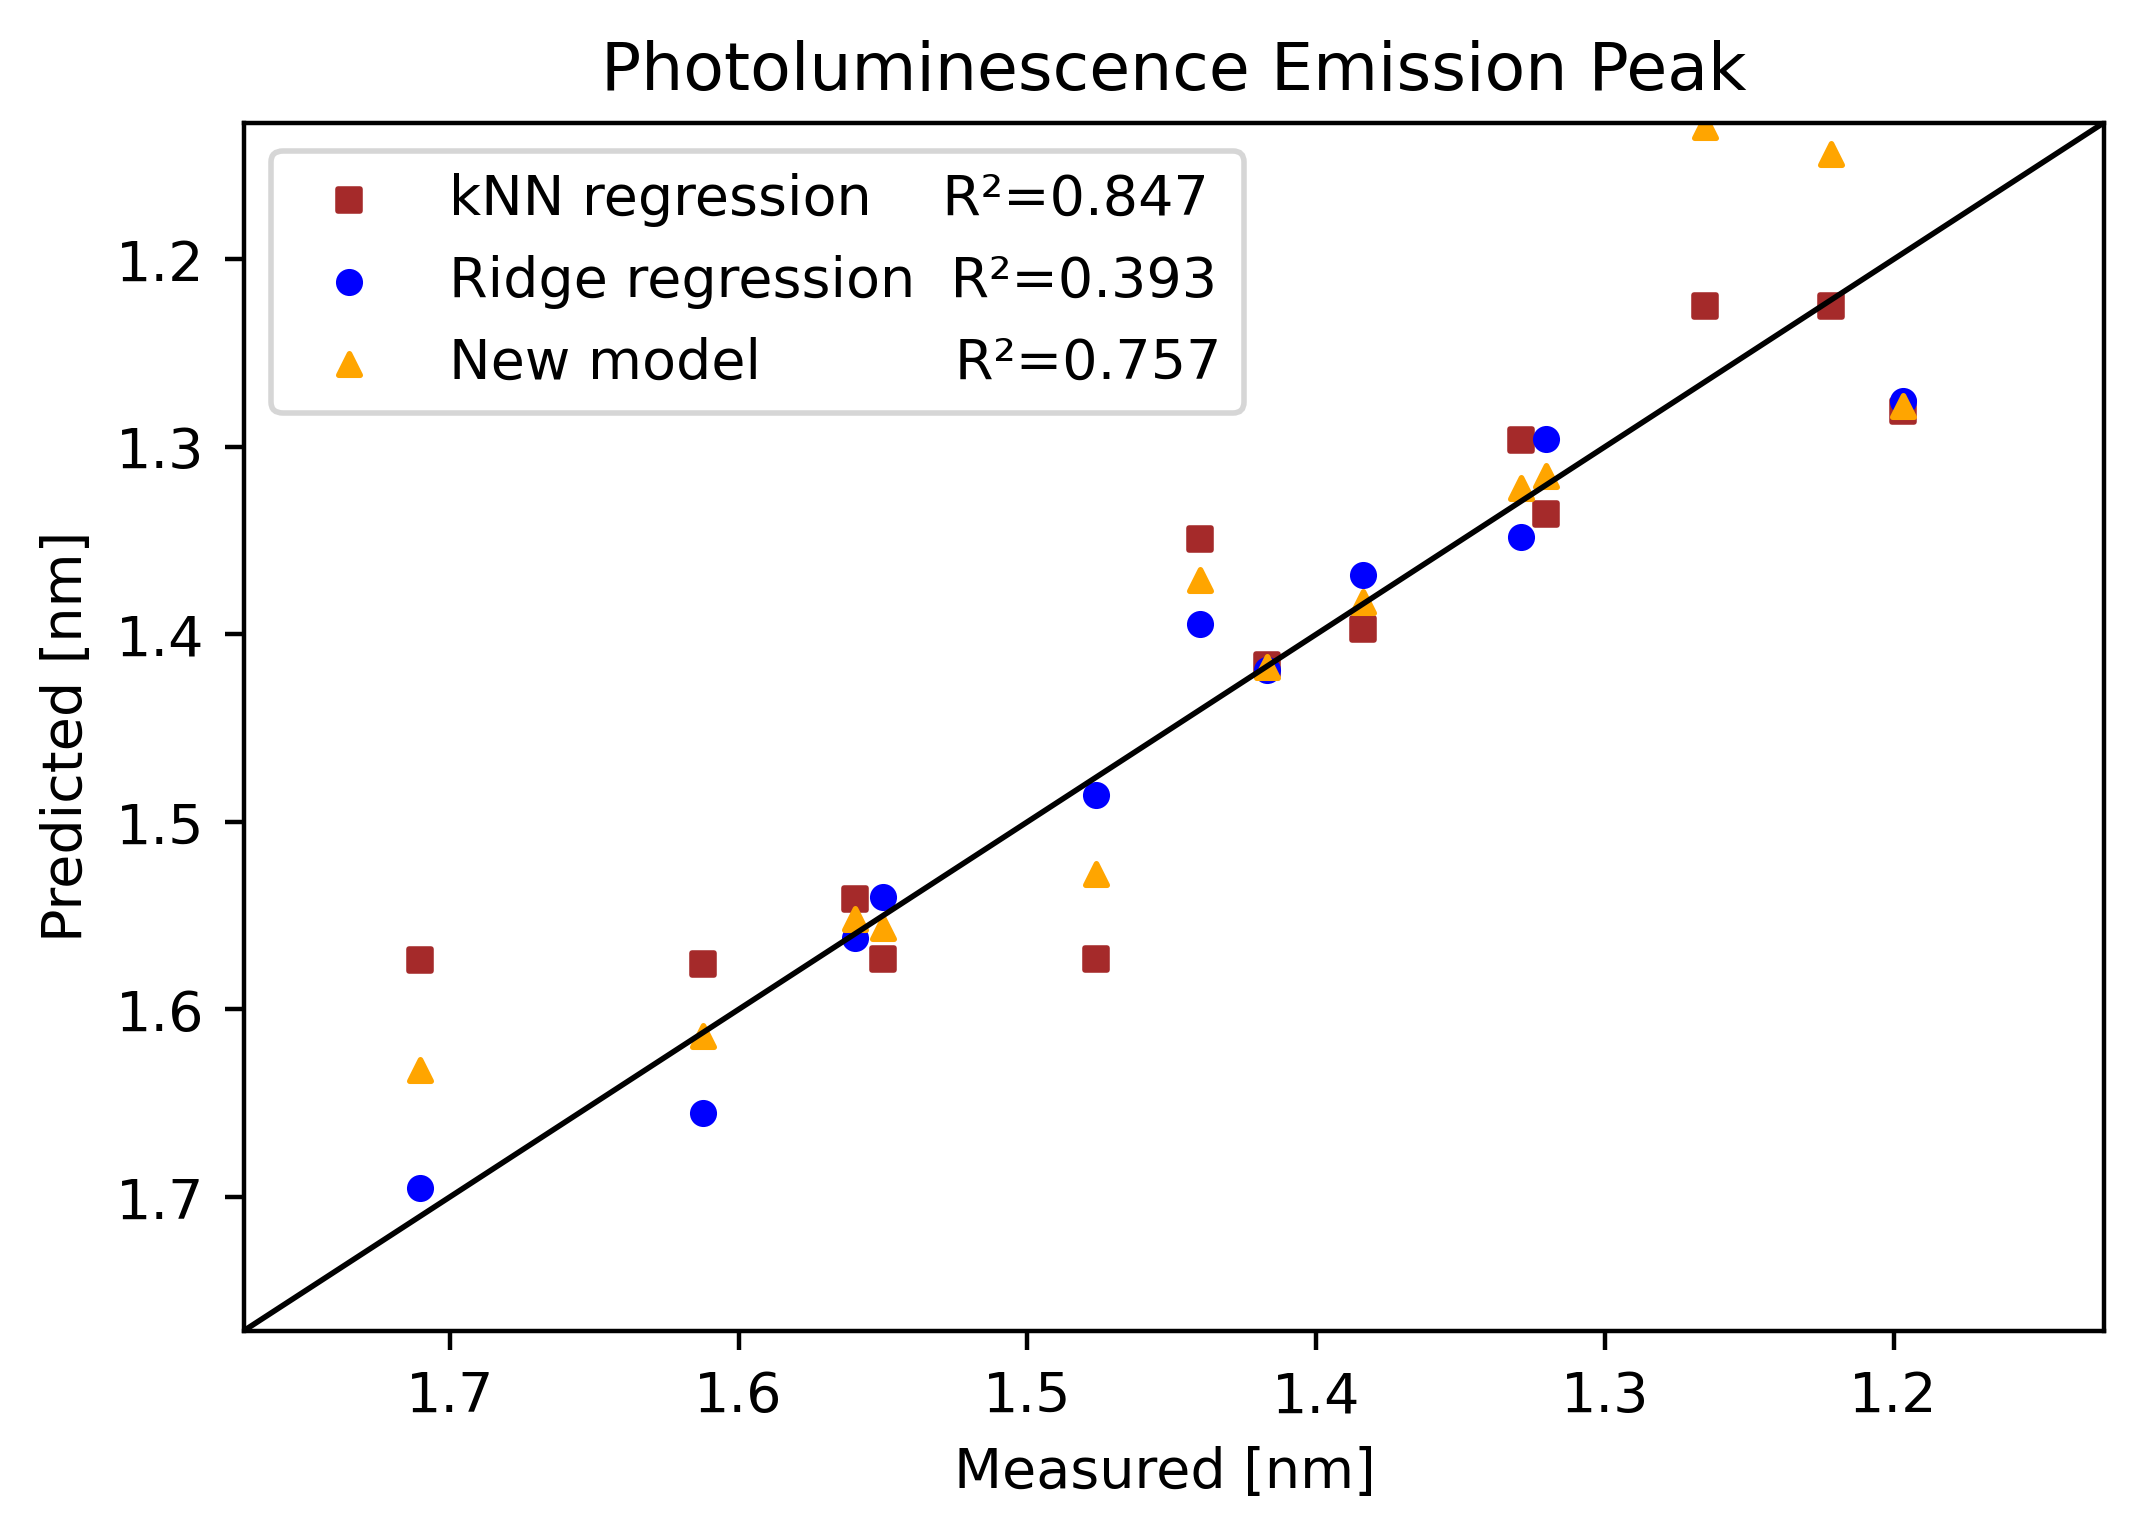

In [96]:
from sklearn.metrics import r2_score
plt.scatter(1240/y_sample, 1240/knn_y_pred, label="kNN regression""    R²="+str(round(r2_score(y_sample, knn_y_pred),3)),marker='s',s=15,c='brown')
plt.scatter(1240/y_sample, 1240/ridge_y_pred, label="Ridge regression""  R²="+str(round(r2_score(y_sample, ridge_y_pred),3)),marker='o',s=15,c='blue')
plt.scatter(1240/y_sample, 1240/new_y_pred, label="New model""           R²="+str(round(r2_score(y_sample, new_y_pred),3)),marker='^',s=15,c='orange')
plt.legend()
plt.xlim([1240/700, 1240/1100])
plt.ylim([1240/700, 1240/1100])
plt.xlabel("Measured [nm] ")
plt.ylabel("Predicted [nm] ")
plt.title("Photoluminescence Emission Peak")
x =  np.linspace(1240/700, 1240/1100, 2)
y =x
plt.plot(x,y, color='black',linewidth=1,linestyle='-')